## Importing libraries, parameters.py

In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'INP file examples\\chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=INP file examples\chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_Otomo2018_without_O


In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
import random   # random number generator
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made
import json   # convert dictionary to string

# my own file:
already_imported = 'gd' in globals()
try:
    import gradient_descent as gd
except:
    try:
        import Bubble_dynamics_simulation.gradient_descent as gd
    except:
        print(colored(f'Error, \'gradient_descent.py\' not found', 'red'))
if already_imported: importlib.reload(gd)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


## Define ranges

In [3]:
"""Control parameter ranges and division"""
# a list for each control parameter, containing all the possible values

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1e-6*x for x in [5.0, 125.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0],
    # indexes of species in initial bubble
    gases=[[par.index['N2'], par.index['H2']]],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions=[[0.25, 0.75]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [1.0]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [20.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [0.35],
    # vapour pressure [Pa]
    #P_v = par.P_v, # calculated from T_inf
    # dynamic viscosity [Pa*s]
    #mu_L = par.mu_L, # calculated from T_inf
    # density [kg/m^3]
    rho_L =  [998.20],
    # sound speed [m/s]
    c_L = [par.c_L],
    # surfactant (surface tension modfier) [-]
    surfactant = [1.0],
  # Excitation parameters: (excitation_type = sin_impulse)
    # excitation amplitude [Pa]
    p_A = [-x * par.bar2Pa for x in [1.0, 3.0]], # [bar --> Pa]
    # excitation frequency [Hz]
    freq =  [10000.0, 50000.0],
    # excitation duration in period times [-]
    n =  [1.00],
)

for key in gd.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

Starting the searches from random points is not a good practice. You may start them from the best points of a bruteforce search. Alternatively, you can use trial_points, and only use the best searches points as start points.

index:      146/240;   success: True;   runtime:  111.03 [s]   |   R_E= 9.086300e-06;   p_A=-2.241950e+05;   freq= 1.079663e+04;   |   NH3 production:  9.287433e+05 [MJ/kg] (best:  902.6 [MJ/kg])                                                   
DONE
total time:  213.81 [s]   ( 0.89 [s/run])
best energy_demand:  9.025881e+02 [MJ/kg]
12th energy_demand:  1.217664e+03 [MJ/kg]


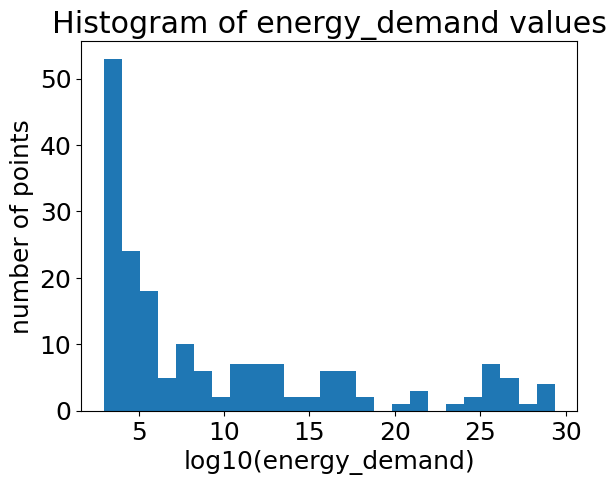

In [4]:
# create folder for parameter study results:
save_path = 'test_GD_1atm_3D'
file = gd.de.Make_dir(save_path)
to_optimize = 'energy_demand'   # key in data from de.get_data()
searches = 12    # number os total searches
trial_points = 240  # number of trial start_points. best ones will be used for searches


kwargs_list = [
    dict(
        point=gd.rand_point(ranges, ID=i, padding=0.001),
        to_optimize=to_optimize,
        t_int=[0.0, 1.0],
        LSODA_timeout=30,
        Radau_timeout=300,
    )
for i in range(trial_points)]
best_energy_demand = 1e30
start_points = []

start = time.time()
file.new_file()
with Pool(processes=cpu_count(), maxtasksperchild=100) as pool:
    results = pool.imap_unordered(gd.evaluate_kwargs, kwargs_list)

    for result in results:
        data, point, success = result
        data = gd.de.dotdict(data)
        file.write_line(data)
        start_points.append(point)
      # print stuff:
        if data.energy_demand > 0 and data.energy_demand < best_energy_demand:
            best_energy_demand = data.energy_demand
        to_print = [f'{key}={data[key]: e};   ' for key in ranges if len(ranges[key]) == 2]
        to_print = ''.join(to_print)
        print(f'index: {data.ID: >8}/{len(kwargs_list)};   success: {success};   runtime: {data.elapsed_time: 6.2f} [s]   |   ' + to_print + '|   ' +
              f'{gd.de.target_specie} production: {data.energy_demand: e} [MJ/kg] (best: {best_energy_demand: .1f} [MJ/kg])'+
              '                                                 ', end='\r')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\nDONE')
print(f'total time: {elapsed: .2f} [s]   ({(elapsed / len(kwargs_list)): .2f} [s/run])')

start_points.sort(key=lambda point: point['output'])
outputs = [np.log10(point['output']) for point in start_points if point['output'] < 1e30]
print(f'best energy_demand: {start_points[0]["output"]: e} [MJ/kg]')
print(f'{searches}th energy_demand: {start_points[searches-1]["output"]: e} [MJ/kg]')
plt.hist(outputs, bins=25)
plt.xlabel('log10(energy_demand)')
plt.ylabel('number of points')
plt.title('Histogram of energy_demand values')
plt.show()

In [5]:
kwargs_list = [dict(
    ranges=ranges,
    path=save_path,
    to_optimize=to_optimize,
    start_point=start_point,
    step_limit=200,
    first_step=0.01,
    min_step=1e-4,
    delta=1e-5,
    verbose=False,
    t_int=[0.0, 1.0],
    LSODA_timeout=30.0,
    Radau_timeout=300.0,
    ) for start_point in start_points[:searches]]

# Run gradient_search() multithread

In [6]:
"""Save settings as txt"""

# save all settings (full_bubble_model.py, parameters.py, ranges) as txt:
to_print = gd.de.copy(kwargs_list[0])
del to_print['ranges']
del to_print['start_point']
ranges_str = f'''
gradient descent general settings:
    to_optimize = '{to_optimize}'   # key in data from de.get_data()
    searches = {searches}    # number os total searches
    trial_points = {trial_points}  # number of trial start_points. best ones will be used for searches

ranges = {json.dumps(ranges, indent=4)}

settings = {json.dumps(to_print, indent=4)}

start_points = [
'''

for kwargs in kwargs_list[:searches]:
    ranges_str += json.dumps(kwargs['start_point'], indent=4) + ',\n'
ranges_str += ']'

file.write_string(ranges_str, 'gradient_descent_settings')

In [7]:
"""Gradient method, multithread"""

best_output = 1.0e30
num = 0
to_plot = []
last_points = []
start = time.time()

with Pool(processes=cpu_count(), maxtasksperchild=10) as pool:
    results = pool.imap_unordered(gd.search, kwargs_list)
    for result in results:
        last_data, best_outputs, elapsed = result
        num += 1
        to_plot.append(best_outputs)
        last_points.append(last_data)
        if best_outputs[-1] < best_output and best_outputs[-1] > 0:
            best_output = best_outputs[-1]
        
        # print stuff:
        print(f'{num: >3}/{searches}: Total {len(best_outputs): <3} steps, finished in {elapsed: 8.2f} [s]   ({(elapsed / len(best_outputs)): 6.2f} [s/step])   '+
              f'Final {to_optimize}: {best_outputs[-1]: 8.1f} (best: {best_output: 6.1f})')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {((elapsed-elapsed % 3600) / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / searches): .2f} [s/search])')

  1/12: Total 49  steps, finished in  1400.57 [s]   ( 28.58 [s/step])   Final energy_demand:    882.0 (best:  882.0)
  2/12: Total 71  steps, finished in  1886.80 [s]   ( 26.57 [s/step])   Final energy_demand:    861.2 (best:  861.2)
  3/12: Total 200 steps, finished in  2391.30 [s]   ( 11.96 [s/step])   Final energy_demand:    946.2 (best:  861.2)
  4/12: Total 200 steps, finished in  2501.82 [s]   ( 12.51 [s/step])   Final energy_demand:    937.5 (best:  861.2)
  5/12: Total 200 steps, finished in  2624.02 [s]   ( 13.12 [s/step])   Final energy_demand:    916.9 (best:  861.2)
  6/12: Total 200 steps, finished in  2868.60 [s]   ( 14.34 [s/step])   Final energy_demand:    887.3 (best:  861.2)
  7/12: Total 200 steps, finished in  2887.76 [s]   ( 14.44 [s/step])   Final energy_demand:    901.1 (best:  861.2)
  8/12: Total 200 steps, finished in  2982.05 [s]   ( 14.91 [s/step])   Final energy_demand:    899.0 (best:  861.2)
  9/12: Total 178 steps, finished in  3577.97 [s]   ( 20.10 [s/s

## Plot results

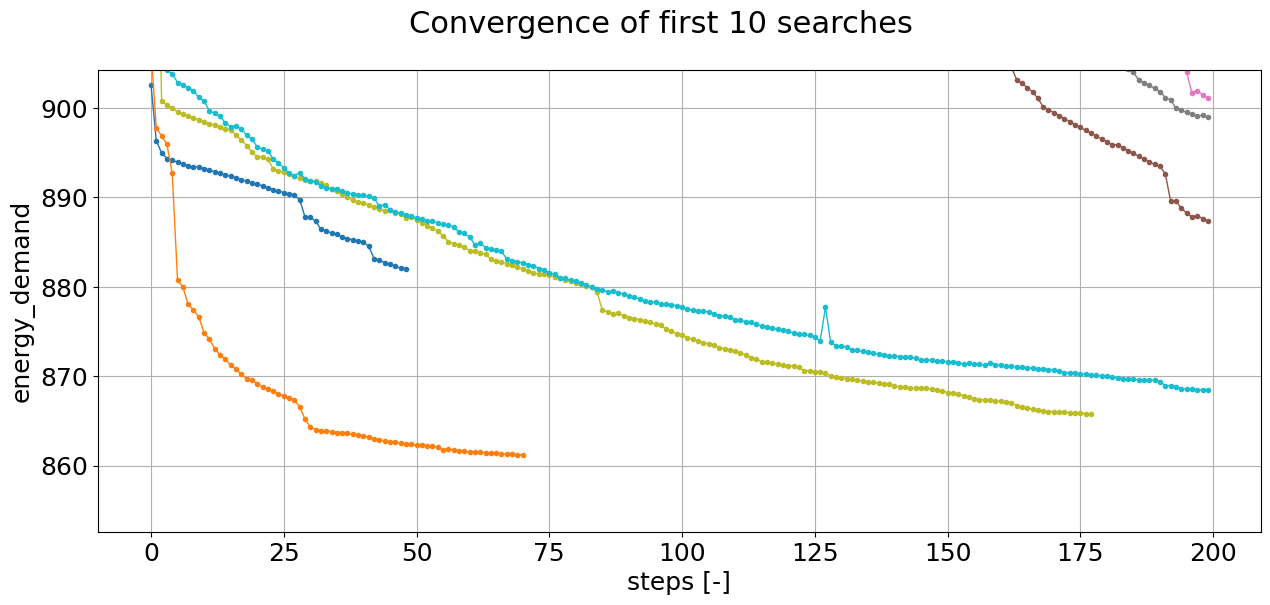

In [8]:
"""Plot convergence of last searches"""

if len(to_plot) > 10:
    to_plot2 = to_plot[:10]
else:
    to_plot2 = to_plot

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Convergence of first 10 searches', fontsize=22)
ax.set_ylabel(f'{to_optimize}')
ax.set_ylim(0.99*best_output, 1.05*best_output)
#ax.set_yscale('log')
ax.set_xlabel('steps [-]')
ax.grid()
for plot in to_plot2:
    ax.plot(plot, '.-', linewidth=1.0)
plt.show()

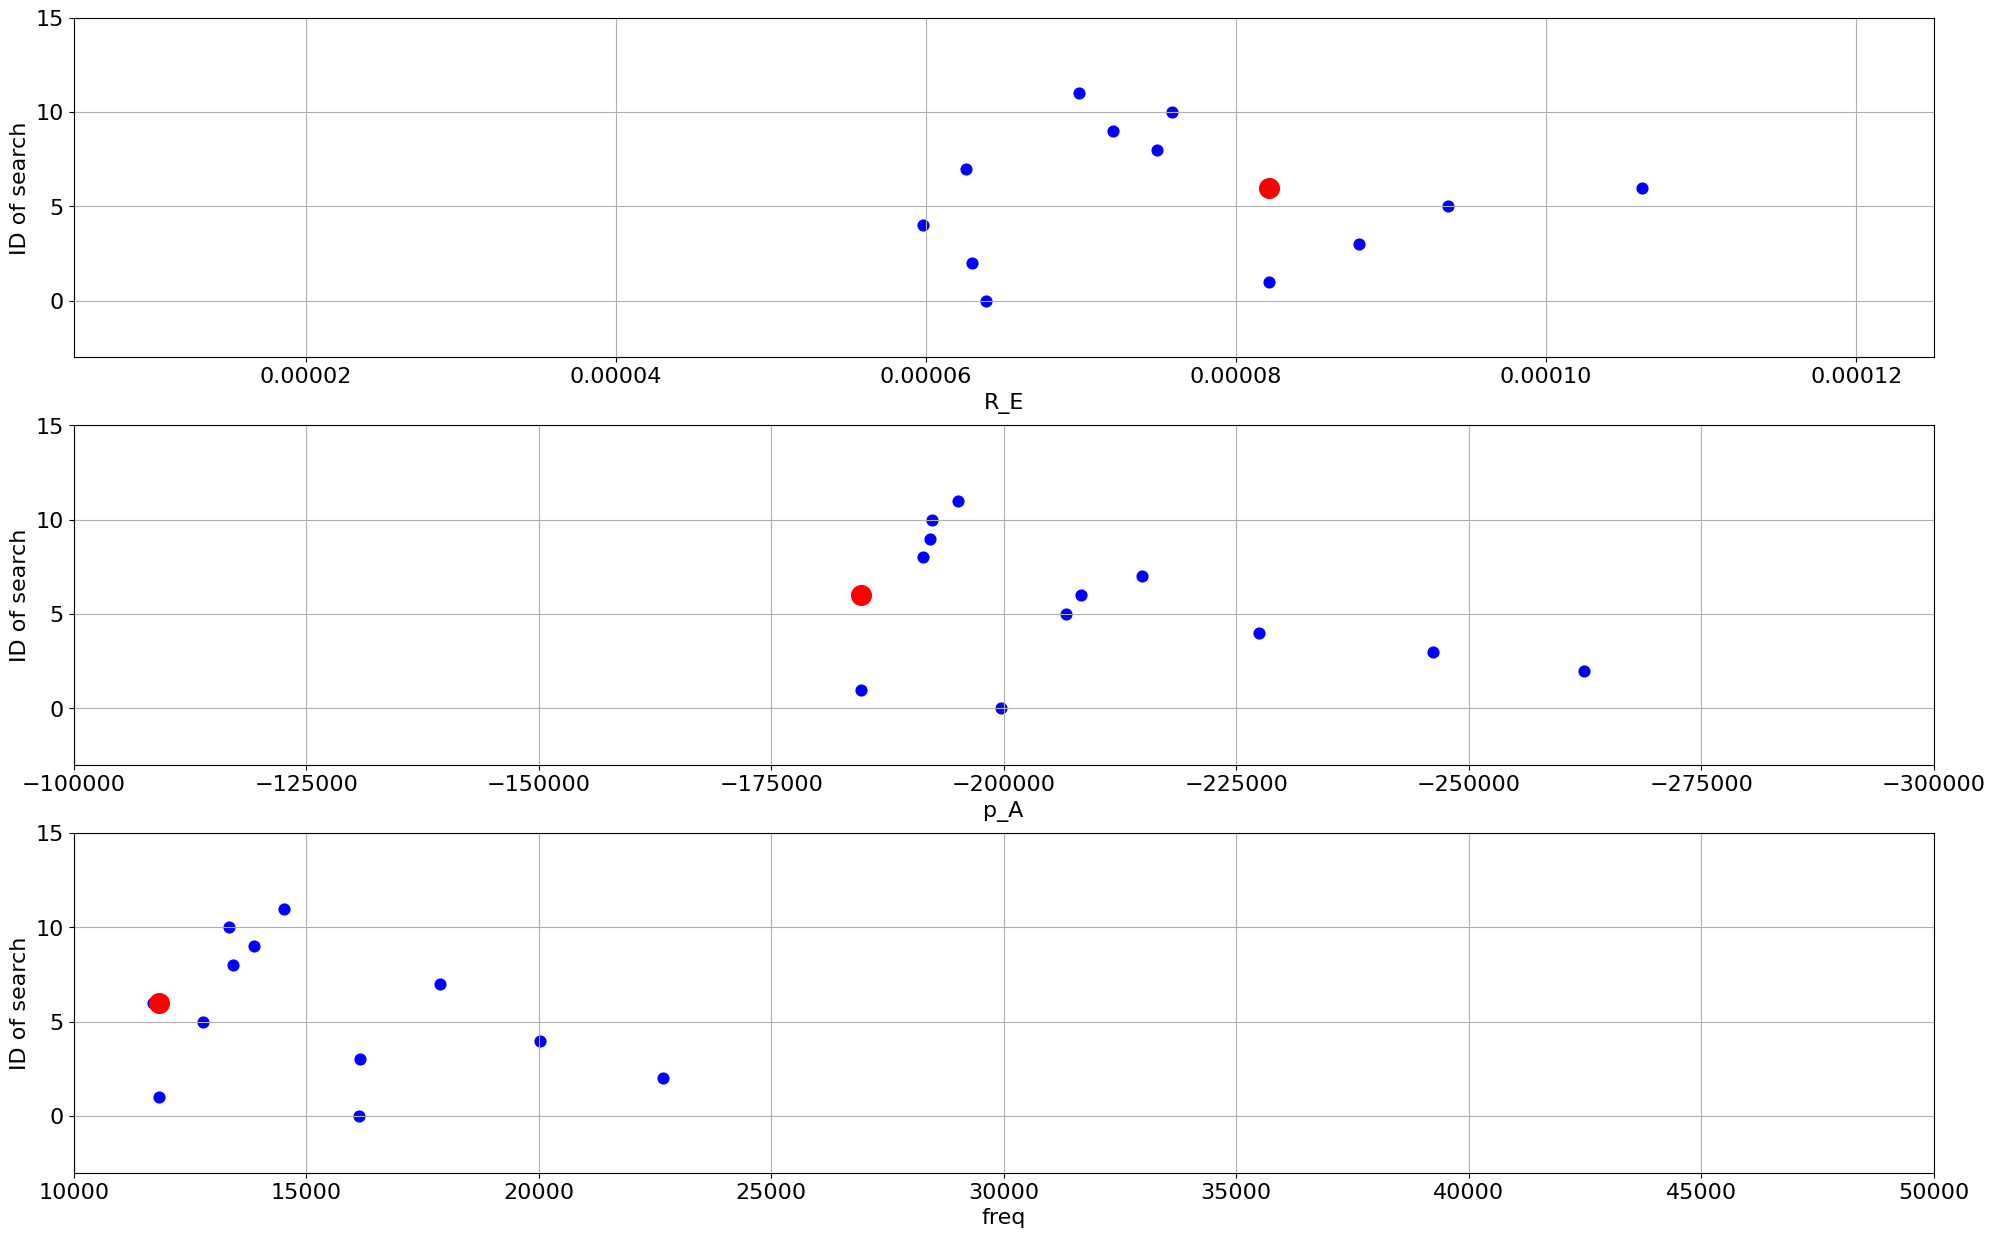

In [9]:
"""Plot the distribution of the optimums"""

plt.rcParams.update({'font.size': 16})
ranges2 = dict()
for key in ranges:
    if len(ranges[key]) > 1:
        ranges2[key] = ranges[key]

n = len(ranges2)
fig, ax = plt.subplots(n, 1, figsize=(24, 5*n))
for i, key in enumerate(ranges2):
    last_values = [last_point[key] for last_point in last_points]
    y = [i for i, last_point in enumerate(last_points)]
        
  # ploting:
    ax[i].scatter(last_values, y, s=60, color='b')
    ax[i].set_ylabel('ID of search')
    ax[i].set_xlabel(key)
    ax[i].set_xlim(ranges2[key])
    n = len(last_points)
    ax[i].set_ylim([-0.25*n, 1.25*n])
    ax[i].grid()
    # best point:
    index = [x[-1] for x in to_plot].index(best_output)
    best_point = last_points[index]
    ax[i].scatter([best_point[key]], [0.5*n], s=200, color='r')
